In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error

In [3]:
# Load the dataset
mat = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines.mat')
mat_gt = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines_gt.mat')

data = mat['indian_pines']
labels = mat_gt['indian_pines_gt']

In [4]:
# Reshape the data to (num_samples, num_features)
n, m, num_samples = data.shape
data_reshaped = np.reshape(data, (n*m, num_samples))
labels_reshaped = np.reshape(labels, (n*m,))

# Perform PCA to reduce the dimensionality of the data
num_components = 16
pca = PCA(n_components=num_components)
data_pca = pca.fit_transform(data_reshaped)

from keras.models import Sequential
from keras.layers import Dense, Conv1D

# Define the neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=data_pca.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(17, activation='softmax'))

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot encoding
num_labels = len(np.unique(labels_reshaped))
labels_onehot = np.eye(num_labels)[labels_reshaped.reshape(-1)]

# print(labels_onehot)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_pca, labels_onehot, test_size=0.3, random_state=42)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)
# Train the neural network on the training set
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the neural network on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

2023-04-20 01:30:17.294392: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 01:30:17.347707: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 01:30:17.348297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 01:30:18.110232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/50
368/368 [==============================] - 1s 2ms/step - loss: 81.0125 - accuracy: 0.4858 - val_loss: 24.8030 - val_accuracy: 0.5340
Epoch 2/50
368/368 [==============================] - 1s 1ms/step - loss: 19.0746 - accuracy: 0.5710 - val_loss: 14.9052 - val_accuracy: 0.5825
Epoch 3/50
368/368 [==============================] - 1s 1ms/step - loss: 14.7585 - accuracy: 0.5886 - val_loss: 15.2981 - val_accuracy: 0.5805
Epoch 4/50
368/368 [==============================] - 1s 1ms/step - loss: 11.5998 - accuracy: 0.5964 - val_loss: 11.5877 - val_accuracy: 0.6104
Epoch 5/50
368/368 [==============================] - 1s 1ms/step - loss: 10.7244 - accuracy: 0.5998 - val_loss: 10.4174 - val_accuracy: 0.5853
Epoch 6/50
368/368 [==============================] - 1s 1ms/step - loss: 8.7987 - accuracy: 0.6116 - val_loss: 9.3383 - val_accuracy: 0.6182
Epoch 7/50
368/368 [==============================] - 1s 2ms/step - loss: 7.9018 - accuracy: 0.6172 - val_loss: 9.7241 - val_accuracy: 0.5

658/658 [==============================] - 1s 782us/step
Clustered labels accuracy: 0.7045422116527943
MSE: 28.4192627824019


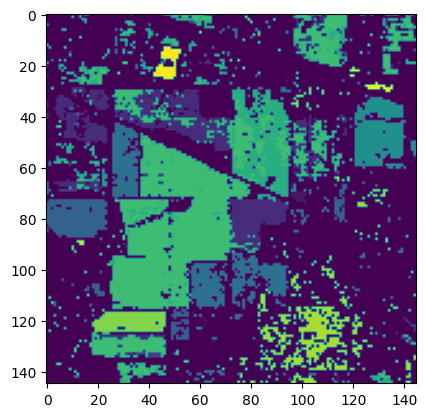

In [5]:
# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_pca)
# smoothed_preds = np.apply_along_axis(lambda x: np.convolve(x, [1/3, 1/3, 1/3], mode='same'), axis=1, arr=cluster_labels_onehot)
cluster_labels = np.argmax(cluster_labels_onehot, axis=1)

cluster_labels_reshaped = np.reshape(cluster_labels, (n, m))
accuracy = np.mean(cluster_labels_reshaped == labels)
print("Clustered labels accuracy:", accuracy)

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
plt.imshow(cluster_labels_reshaped)
plt.show()

658/658 [==============================] - 1s 781us/step


100%|██████████| 299/299 [00:00<00:00, 314.80it/s]


Best sigma=1.3 with accuracy=0.7400
MSE: 28.595148632580262


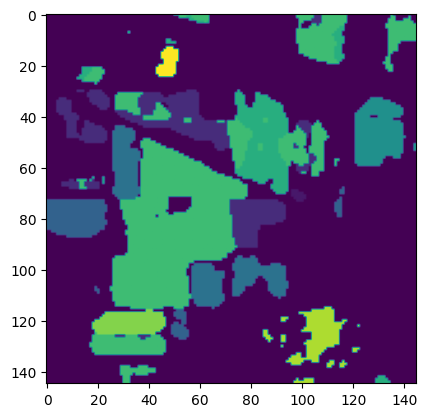

In [7]:
import cv2
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

sigmas = np.arange(0.01, 3.00, 0.01)  # different values of sigma to try
best_accuracy = 0
best_sigma = 0

# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_pca)
preds = np.reshape(cluster_labels_onehot, (n, m, 17))

for sigma in tqdm(sigmas):
    smoothed_preds = cv2.GaussianBlur(preds, (0, 0), sigma)

    cluster_labels_reshaped = np.argmax(smoothed_preds, axis=2)
    accuracy = np.mean(cluster_labels_reshaped == labels)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sigma = sigma
        best_image = cluster_labels_reshaped

print(f"Best sigma={best_sigma:.1f} with accuracy={best_accuracy:.4f}")

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
plt.imshow(best_image)
plt.show()